In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as T
from torchvision.io import read_image

from PIL import Image
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

!pip install torchinfo -q
from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'running on the {device}')

running on the cuda


###  get images

In [ ]:
# set default images
!wget -q https://cdn.pixabay.com/photo/2018/07/14/15/27/cafe-3537801_1280.jpg
!wget -q https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

content_path = Path(r'/content/cafe-3537801_1280.jpg')
style_path = Path(r'/content/Vassily_Kandinsky,_1913_-_Composition_7.jpg')


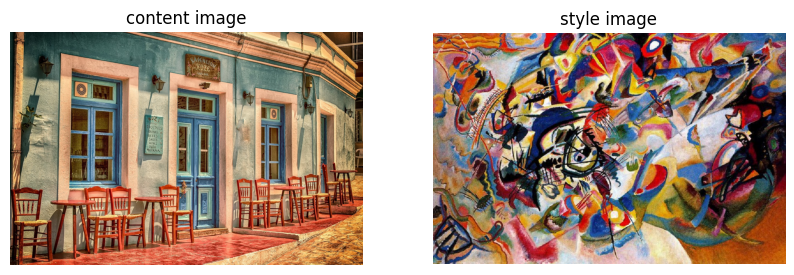

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
img = Image.open(content_path)
axs[0].imshow(img)
axs[0].set_title("content image")
axs[0].axis('off')

img = Image.open(style_path)
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title("style image")
plt.show()

In [ ]:
weights = torchvision.models.vgg.VGG19_Weights.DEFAULT
model = torchvision.models.vgg19(weights).features.to(device) # we only need the features head

# freeze weights
for param in model.parameters():
  param.requires_grad=False

model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 79.4MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
## display content image and style image
def load_image(img_path, max_size = 400, shape=None):
  # read image
  img = Image.open(img_path)

  if max(img.size) > max_size:
    size = max_size
  else:
    size = max(img.size)

  if shape is not None:
    size = shape

  transform = T.Compose([
      T.Resize(size),
      T.ToTensor(),
      T.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))
  ])

  img = transform(img).unsqueeze(dim=0)
  return img

In [ ]:
style_img = load_image(style_path).to(device)
content_img = load_image(content_path, shape=style_img.shape[-2:]).to(device)

In [ ]:
# code to convert from normalized
def im_convert(tensor):
  image = tensor.to('cpu').clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)

  return image

## VGG Model

In [ ]:
def get_features(image, model, layers=None):

  if layers is None:
    layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

  features = {}
  x = image
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x

  return features


In [ ]:
## compute gram matrix
def gram_matrix(tensor):
  _, c, h, w = tensor.shape
  tensor = tensor.view(c, h * w)

  # calculate the gram matric
  gram = torch.mm(tensor, tensor.T)

  return gram


In [ ]:
content_feats = get_features(content_img, model)
style_feats = get_features(style_img, model)

# compute gram matri for each layer of the style representation
style_grams = {layer: gram_matrix(style_feats[layer]) for layer in style_feats}

# create clone of content image to use as starting image of target,
# iteratively change its style
target = content_img.clone().requires_grad_(True).to(device)

## loss weights

In [ ]:
# style weights
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

## iteration loop

total_loss: 127.98898315429688


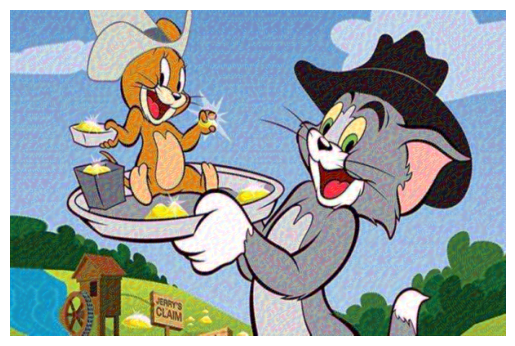

total_loss: 55.02130126953125


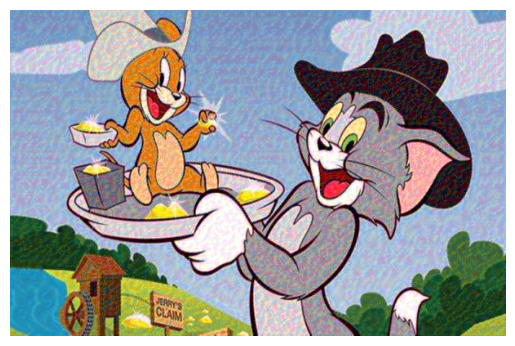

total_loss: 31.013429641723633


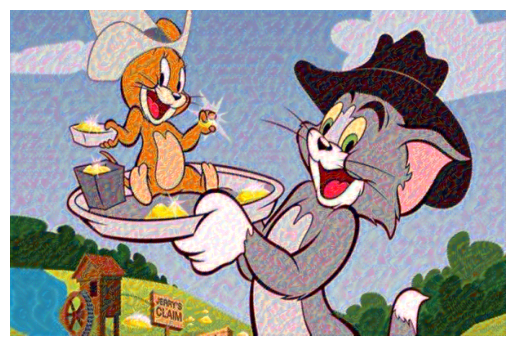

total_loss: 20.061796188354492


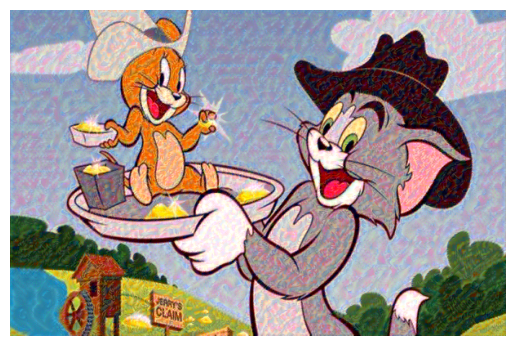

total_loss: 14.118430137634277


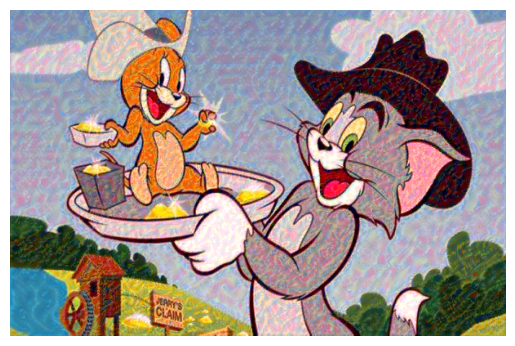

In [ ]:
show_every = 400

# were optimizing the image
optimizer = torch.optim.Adam([target], lr=1e-3)
# steps
steps = 2000

for iter in range(1, steps+1):
  # get features from your target image
  target_features = get_features(target, model)

  # the content loss
  content_loss = torch.mean(target_features['conv4_2'] - content_feats['conv4_2'])
  # the style loss
  # initialize style loss to 0
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape

    # get the "style" style representation
    style_gram = style_grams[layer]
    # style loss for one layer weighted appropriately
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    # add to the style loss
    style_loss += layer_style_loss / (d * h * w)

  # calculate the total loss
  total_loss = content_weight * content_loss + style_loss

  # update target image
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if iter % show_every == 0:
    print(f"total_loss: {total_loss.item()}")
    plt.imshow(im_convert(target))
    plt.show()
